In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

In [2]:
def compute_gradient(y, tx, w):
    """Compute the gradient."""
    e = y - tx.dot(w)
    
    return - 1/len(y) * np.transpose(tx).dot(e)


def gradient_descent(y, tx, initial_w, max_iters, gamma, verbose=True):
    """Gradient descent algorithm."""
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        grad = compute_gradient(y, tx, w)
        loss = compute_loss(y, tx, w)
        # update w
        w = w - gamma * grad
        # store w and loss
        ws.append(w)
        losses.append(loss)
        if verbose:
            print("Gradient Descent({bi}/{ti}): loss={l}, w0={w0}, w1={w1}".format(
              bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]))

    return losses, ws

In [3]:
def compute_loss(y, tx, w, loss_function='mse'):
    """Calculate the loss.

    You can calculate the loss using mse or mae.
    """
    if loss_function == 'mse':   
        e = y - tx.dot(w)
    
        return 1/(2 * len(y)) * np.transpose(e).dot(e)

    elif loss_function == 'mae':
        e = y - tx.dot(w)
        
        return 1/len(y) * sum(np.abs(e))
    
    else:
        raise NotImplementedError

# 1 Least squares and linear basis functions models
## 1.1 Least squares

In [4]:
def least_squares(y, tx):
    """calculate the least squares solution."""
    tx_t = np.transpose(tx)
    return np.linalg.solve(tx_t.dot(tx), tx_t.dot(y))

In [5]:
y = np.array([200, -200])
tx = np.array([[401, -201], [-800, 401]])
print(least_squares(y, tx))

[39999.73208561 79799.46550679]


### Load the data
Here we will reuse the dataset `height_weight_genders.csv` from previous exercise section to check the correctness of your implementation. Please compare it with your previous result.

In [6]:
from helpers import *
def test_your_least_squares():
    height, weight, gender = load_data_from_ex02(sub_sample=False, add_outlier=False)
    x, mean_x, std_x = standardize(height)
    y, tx = build_model_data(x, weight)
    w_least_squares = least_squares(y, tx)
    w_initial = np.array([0, 0])
    w_gradient_descent = gradient_descent(y, tx, w_initial, 50, .1, verbose=False)[1][-1]
    print(w_least_squares)
    print(w_gradient_descent)

Test it here

In [7]:
test_your_least_squares()

[73.293922   13.47971243]
[72.9161816  13.41024103]


## 1.2 Least squares with a linear basis function model
Start from this section, we will use the dataset `dataEx3.csv`.

### Implement polynomial basis functions

In [8]:
# load dataset
x, y = load_data()
print("shape of x {}".format(x.shape))
print("shape of y {}".format(y.shape))

shape of x (50,)
shape of y (50,)


In [9]:
def build_poly(x, degree):
    """polynomial basis functions for input data x, for j=0 up to j=degree."""
    return np.column_stack([x**i for i in range(degree+1)])

Let us play with polynomial regression. Note that we will use your implemented function `compute_mse`. Please copy and paste your implementation from exercise02.

In [10]:
from plots import *

def polynomial_regression():
    """Constructing the polynomial basis function expansion of the data,
       and then running least squares regression."""
    # define parameters
    degrees = [1, 3, 7, 12]
    
    # define the structure of the figure
    num_row = 2
    num_col = 2
    f, axs = plt.subplots(num_row, num_col)

    for ind, degree in enumerate(degrees):
        
        x_d = build_poly(x, degree)
        
        weights = least_squares(y, x_d)
        rmse = np.sqrt(2 * compute_loss(y, x_d, weights))
        print(x_d.shape)
        print(y.shape)
        print("Processing experiment #{i}, degree={d}, rmse={loss}".format(
              i=ind + 1, d=degree, loss=rmse))
        # plot fit
        plot_fitted_curve(
            y, x, weights, degree, axs[ind // num_col][ind % num_col])
    plt.tight_layout()
    plt.savefig("visualize_polynomial_regression")
    plt.show()

Run polynomial regression

(50, 2)
(50,)
Processing experiment #1, degree=1, rmse=0.4718760796342188
(50, 4)
(50,)
Processing experiment #2, degree=3, rmse=0.258582776677375
(50, 8)
(50,)
Processing experiment #3, degree=7, rmse=0.24965870360907347
(50, 13)
(50,)
Processing experiment #4, degree=12, rmse=0.24337224835787005


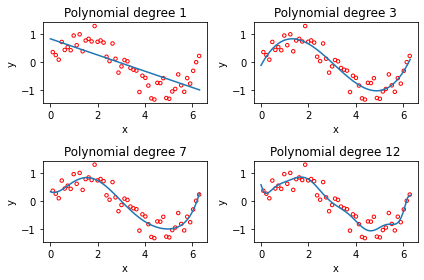

In [11]:
polynomial_regression()

# 2 Evaluating model predication performance


Let us show the train and test splits for various polynomial degrees. First of all, please fill in the function `split_data()`

In [12]:
def split_data(x, y, ratio, seed=1):
    """
    split the dataset based on the split ratio. If ratio is 0.8 
    you will have 80% of your data set dedicated to training 
    and the rest dedicated to testing
    """
    # set seed
    np.random.seed(seed)
    p = np.random.permutation(len(x))
    x, y = x[p], y[p]
    split_ind = int(ratio * len(x))
    return x[:split_ind], x[split_ind:], y[:split_ind], y[split_ind:]

Then, test your `split_data` function below.

In [13]:
def train_test_split_demo(x, y, degree, ratio, seed):
    """polynomial regression with different split ratios and different degrees."""
    x_train, x_test, y_train, y_test = split_data(x, y, ratio, seed)
    x_train = build_poly(x_train, degree)
    x_test = build_poly(x_test, degree)
    w = least_squares(y_train, x_train)
    rmse_tr = np.sqrt(2 * compute_loss(y_train, x_train, w))
    rmse_te = np.sqrt(2 * compute_loss(y_test, x_test, w))
    print("proportion={p}, degree={d}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
          p=ratio, d=degree, tr=rmse_tr, te=rmse_te))

In [14]:
seed = 6
degrees = [1, 3, 7, 12]
split_ratios = [0.9, 0.5, 0.1]

for split_ratio in split_ratios:
    for degree in degrees:
        train_test_split_demo(x, y, degree, split_ratio, seed)

proportion=0.9, degree=1, Training RMSE=0.494, Testing RMSE=0.181
proportion=0.9, degree=3, Training RMSE=0.264, Testing RMSE=0.206
proportion=0.9, degree=7, Training RMSE=0.254, Testing RMSE=0.220
proportion=0.9, degree=12, Training RMSE=0.242, Testing RMSE=0.254
proportion=0.5, degree=1, Training RMSE=0.455, Testing RMSE=0.531
proportion=0.5, degree=3, Training RMSE=0.239, Testing RMSE=0.296
proportion=0.5, degree=7, Training RMSE=0.232, Testing RMSE=0.284
proportion=0.5, degree=12, Training RMSE=0.205, Testing RMSE=1.531
proportion=0.1, degree=1, Training RMSE=0.428, Testing RMSE=0.534
proportion=0.1, degree=3, Training RMSE=0.085, Testing RMSE=0.460
proportion=0.1, degree=7, Training RMSE=0.000, Testing RMSE=1.990
proportion=0.1, degree=12, Training RMSE=0.000, Testing RMSE=2.911


# 3 Ridge Regression
Please fill in the function below.

In [28]:
def ridge_regression(y, tx, lambda_):
    """implement ridge regression."""
    tx_t = np.transpose(tx)
    weights = np.linalg.solve(tx_t.dot(tx) + lambda_ * np.identity(tx_t.shape[0]), tx_t.dot(y))
    rmse = np.sqrt(2 * compute_loss(y, tx, weights))
    return weights, rmse

In [31]:
def ridge_regression_demo(x, y, degree, ratio, seed):
    """ridge regression demo."""
    # define parameter
    lambdas = np.logspace(-5, 0, 15)
    # split the data, and return train and test data
    x_train, x_test, y_train, y_test = split_data(x, y, ratio, seed=seed)
    # ***************************************************
    # INSERT YOUR CODE HERE
    # form train and test data with polynomial basis function: TODO
    # ***************************************************
    x_train = build_poly(x_train, degree)
    x_test = build_poly(x_test, degree)

    rmse_tr = []
    rmse_te = []
    for ind, lambda_ in enumerate(lambdas):
        # ridge regression with a given lambda
        w, tr = ridge_regression(y_train, x_train, lambda_)
        te = np.sqrt(2 * compute_loss(y_test, x_test, w))
        rmse_tr.append(tr)
        rmse_te.append(te)
        print("proportion={p}, degree={d}, lambda={l:.3f}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
               p=ratio, d=degree, l=lambda_, tr=rmse_tr[ind], te=rmse_te[ind]))
        
    # Plot the obtained results
    plot_train_test(rmse_tr, rmse_te, lambdas, degree)

proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.227, Testing RMSE=0.338
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.227, Testing RMSE=0.338
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.227, Testing RMSE=0.338
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.227, Testing RMSE=0.338
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.227, Testing RMSE=0.338
proportion=0.5, degree=7, lambda=0.001, Training RMSE=0.227, Testing RMSE=0.338
proportion=0.5, degree=7, lambda=0.001, Training RMSE=0.227, Testing RMSE=0.337
proportion=0.5, degree=7, lambda=0.003, Training RMSE=0.227, Testing RMSE=0.336
proportion=0.5, degree=7, lambda=0.007, Training RMSE=0.227, Testing RMSE=0.335
proportion=0.5, degree=7, lambda=0.016, Training RMSE=0.228, Testing RMSE=0.334
proportion=0.5, degree=7, lambda=0.037, Training RMSE=0.229, Testing RMSE=0.333
proportion=0.5, degree=7, lambda=0.085, Training RMSE=0.229, Testing RMSE=0.328
proportion=0.5, degree=7, lambda=0.193, 

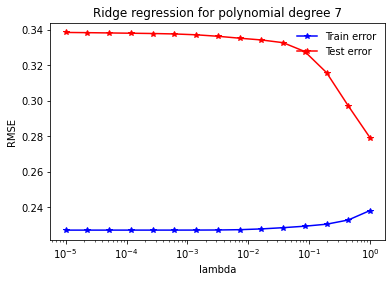

In [32]:
seed = 56
degree = 7
split_ratio = 0.5
ridge_regression_demo(x, y, degree, split_ratio, seed)